# Tensorflow Road Signs YOLO Debugging Notebook

## Setup

In [1]:
# Import packages from the Python standard library
import warnings
from pathlib import Path

# Please enter custom username here.
USERNAME = "jglasbrenner"

# Filter out warning messages
warnings.filterwarnings("ignore")

# Experiment name (note the username_ prefix convention)
EXPERIMENT_NAME = f"{USERNAME}_roadsigns_yolo"

# Import third-party Python packages
import cloudpickle
import imgaug as ia
import numpy as np
import tensorflow as tf
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from mitre.securingai import pyplugs
from mitre.securingai.sdk.utilities.contexts import plugin_dirs

# Import utils.py file
import utils

# Create random number generator
rng = np.random.default_rng(54399264723942495723666216079516778448)

In [2]:
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
ROADSIGNS_TRAINING_DIR = DATA_DIR / "roadsigns" / "training"
ROADSIGNS_TESTING_DIR = DATA_DIR / "roadsigns" / "testing"
YOLO_MOBILENETV2_MODEL_DIR = MODELS_DIR / "roadsigns_yolo_mobilenetv2_yolo" / "1"

PREDICTIONS_DIR = Path("object_detection_predictions")
PREDICTIONS_NPY = PREDICTIONS_DIR / "predictions.npy"

CUSTOM_OBJECTS_PKL = YOLO_MOBILENETV2_MODEL_DIR / "custom_objects.cloudpickle"
YOLO_MOBILENETV2 = YOLO_MOBILENETV2_MODEL_DIR / "model"

In [3]:
with plugin_dirs(["task-plugins"]):
    from securingai_custom.roadsigns_yolo_estimators import data as data_module

In [4]:
training_ds, validation_ds, n_classes = data_module.create_object_detection_dataset(
    root_directory=ROADSIGNS_TRAINING_DIR,
    image_size=(448, 448, 3),
    seed=80823,
    batch_size=16,
    augment=True,
)

Found 790 images and 1115 bounding boxes belonging to 4 classes.


2022-01-14 13:38:26.562038: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-14 13:38:26.562840: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
testing_ds, n_classes = data_module.create_object_detection_testing_dataset(
    root_directory=ROADSIGNS_TESTING_DIR,
    image_size=(448, 448, 3),
    batch_size=16,
)

Found 87 images and 129 bounding boxes belonging to 4 classes.


In [6]:
training_sample = list(training_ds.take(1).as_numpy_iterator())
testing_sample = list(testing_ds.take(1).as_numpy_iterator())

2022-01-14 13:38:27.208002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


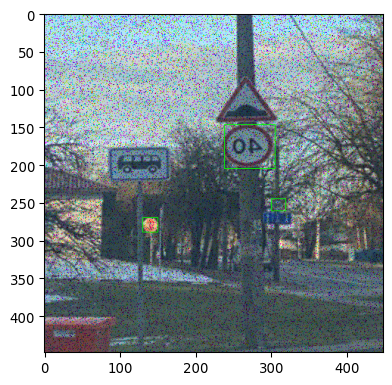

In [11]:
img_batch_idx = 3
train_image, train_labels = training_sample[0]
train_image = train_image[img_batch_idx]
train_labels = train_labels[img_batch_idx]

train_true_obj = train_labels[..., 4]
train_bbox_x_idx, train_bbox_y_idx = np.nonzero(train_true_obj)

train_corner_bboxes = data_module.convert_cellbox_to_corner_bbox_numpy(
    train_labels[..., :4], np.array([7, 7], dtype="int32")
)

train_img_shape = np.shape(train_image)[:2]
train_bbs = BoundingBoxesOnImage(
    [
        BoundingBox(
            x1=train_corner_bboxes[x, y, 0] * train_img_shape[1],
            y1=train_corner_bboxes[x, y, 1] * train_img_shape[0],
            x2=train_corner_bboxes[x, y, 2] * train_img_shape[1],
            y2=train_corner_bboxes[x, y, 3] * train_img_shape[0],
        )
        for x, y in zip(train_bbox_x_idx.tolist(), train_bbox_y_idx.tolist())
    ],
    shape=train_img_shape,
)

ia.imshow(train_bbs.draw_on_image(train_image), backend="matplotlib")

In [5]:
with CUSTOM_OBJECTS_PKL.open("rb") as f, plugin_dirs(["task-plugins"]):
    custom_objects = cloudpickle.load(f)

In [46]:
object_detector = tf.keras.models.load_model(
    YOLO_MOBILENETV2, custom_objects=custom_objects
)

In [134]:
y_pred = object_detector.predict(x)